In [0]:
#Importing Libraries
# Goals: find the traits that link grayscale images with colored ones.
import os
import cv2
import re
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from skimage.io import imsave
from keras.engine import Layer
from scipy import ndimage, misc
from matplotlib import pyplot as plt
from tempfile import TemporaryFile
from skimage.transform import resize
from keras.preprocessing import image
from keras.callbacks import TensorBoard 
from keras.models import model_from_json
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121
from keras.layers.core import RepeatVector, Permute
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Activation, Dense, Dropout, Flatten
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D,  MaxPooling2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
%matplotlib inline 

Using TensorFlow backend.


In [0]:
# Searching for GPU usage
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#mount to google colab 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
images = []
for root, dirnames, filenames in os.walk('/content/drive/Team Drives/DP/ImgConversion/Dataset/Trains/Train/'):
    for filename in filenames:
        if re.search("\.(jpg)$", filename):
            filepath = os.path.join(root, filename)
            image = ndimage.imread(filepath, mode="RGB")
            image_resized = misc.imresize(image, (256, 256))
            images.append(image_resized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


In [0]:
images= np.array(images, dtype=float)
split = int(0.70*len(images))
Xtrain = images[:split]
Xtrain = 1.0/255*Xtrain

In [0]:
#save the array into temporary file 
outfile = TemporaryFile()
# np.save('/content/drive/Team Drives/DP/ImgConversion/Dataset/outfile', Xtrain)

outfile.seek(0) # used it to reopen the file
Xtrain = np.load('/content/drive/Team Drives/DP/ImgConversion/Dataset/outfile.npy')

## Convolutional Neural Network 

In [0]:
model_CNN = Sequential()

# #Input Layer
model_CNN.add(Conv2D(8, (3, 3), input_shape=(256,256,1), activation='relu', padding='same'))

#Hidden Layers
model_CNN.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model_CNN.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(UpSampling2D((2, 2)))
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_CNN.add(UpSampling2D((2, 2)))  # scaling and resizing 
model_CNN.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_CNN.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model_CNN.add(UpSampling2D((2, 2)))
model_CNN.compile(optimizer='rmsprop', loss='mse', metrics = ['accuracy'])

model_CNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 256, 256, 8)       80        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [0]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        #lightess
        X_batch = lab_batch[:,:,:,0]
        #a and b
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

# Train model      
trainedmodel_CNN = model_CNN.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=100)

Epoch 1/100
100/100 [==============================] - 36s 356ms/step - loss: 0.0253 - acc: 0.6576
Epoch 2/100
100/100 [==============================] - 35s 353ms/step - loss: 0.0104 - acc: 0.6575
Epoch 3/100
100/100 [==============================] - 37s 369ms/step - loss: 0.0100 - acc: 0.6640
Epoch 4/100
100/100 [==============================] - 35s 349ms/step - loss: 0.0098 - acc: 0.6588
Epoch 5/100
100/100 [==============================] - 37s 367ms/step - loss: 0.0097 - acc: 0.6605
Epoch 6/100
100/100 [==============================] - 35s 347ms/step - loss: 0.0097 - acc: 0.6661
Epoch 7/100
100/100 [==============================] - 36s 361ms/step - loss: 0.0094 - acc: 0.6657
Epoch 8/100
100/100 [==============================] - 35s 346ms/step - loss: 0.0094 - acc: 0.6625
Epoch 9/100
100/100 [==============================] - 36s 360ms/step - loss: 0.0093 - acc: 0.6640
Epoch 10/100
100/100 [==============================] - 35s 346ms/step - loss: 0.0091 - acc: 0.6652
Epoch 11/

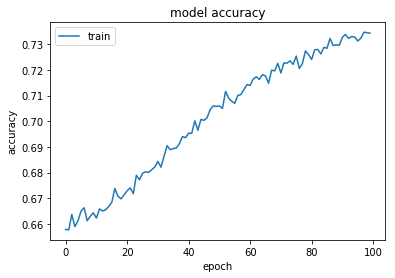

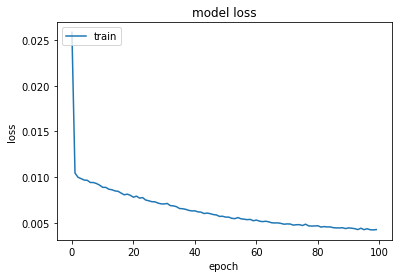

In [0]:
 # summarize history for accuracy
plt.plot(trainedmodel_CNN.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel_CNN.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save and load model 

In [0]:
# Save model
model_CNN_json = model_CNN.to_json()
with open("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_CNN.json", "w") as json_file:
    json_file.write(model_CNN_json)
model_CNN.save_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_CNN.h5")

In [0]:
# load json and create model
json_file = open('/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_CNN.h5")

#### Testing Black and White Images

In [0]:
# Manual Testing of Images
fig, ax = plt.subplots(11,2,figsize = (16,100))
row = 0
colorize = []
print ("Output of model")
for filename in os.listdir('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test'):
  colorize.append(img_to_array(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename)))
  ax[row , 0].imshow(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename),interpolation='nearest')
  row +=1


colorize = np.array(colorize, dtype=float)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict(colorize)
output = output * 128

row =0

# Output colorizations
for i in range(len(output)):
  create_output = np.zeros((256, 256, 3))
  create_output[:,:,0] = colorize[i][:,:,0]
  create_output[:,:,1:] = output[i]
  Image = lab2rgb(create_output)
  ax[row,1].imshow(Image,interpolation='nearest')
  row +=1

Output hidden; open in https://colab.research.google.com to view.

## AutoEncoder + Inception ResNet v2

In [0]:
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

225214464/225209952 [==============================] - 5s 0us/step


#### Build Model

In [0]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model_Incep = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model_Incep.summary()

#### Inception Embbeding

In [0]:
def create_Inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_Inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_Inception_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model_Incep.compile(optimizer='rmsprop', loss='mse',metrics = ['accuracy'])
trainedmodels= model_Incep.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=100)

#### AutoEncoder + Inception ResNetv2 plotting

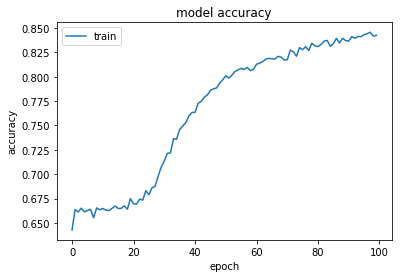

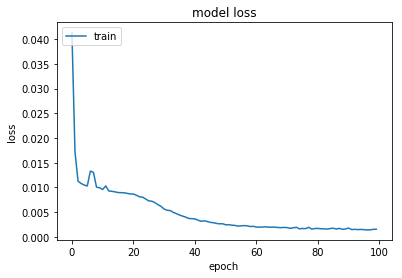

In [0]:
 # summarize history for accuracy
plt.plot(trainedmodels.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodels.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save and Load Model

In [0]:
# Save model
model_Incep_json = model_Incep.to_json()
with open("/content/drive/Team Drives/DP/ImgConversion/model_res.json", "w") as json_file:
    json_file.write(model_Incep_json)
model_Incep.save_weights("/content/drive/Team Drives/DP/ImgConversion/model_res.h5")

In [0]:
# load json and create model
json_file = open('/content/drive/Team Drives/DP/ImgConversion/model_res.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/Team Drives/DP/ImgConversion/model_res.h5")

#### Testing Black and White Images

In [0]:
fig, ax = plt.subplots(11,2,figsize = (16,100))
row = 0
colorize = []
print ("Output of model")

for filename in os.listdir('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test'):
    colorize.append(img_to_array(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename)))
    ax[row , 0].imshow(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename),interpolation='nearest')
    row +=1
    
colorize = np.array(colorize, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*colorize))
colorize_embed = create_Inception_embedding(gray_me)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))

# Test model
output = loaded_model.predict([colorize, colorize_embed])
output = output * 128
row =0


# Output colorizations
for i in range(len(output)):
  create_output = np.zeros((256, 256, 3))
  create_output[:,:,0] = colorize[i][:,:,0]
  create_output[:,:,1:] = output[i]
  Image = lab2rgb(create_output)
  ax[row,1].imshow(Image,interpolation='nearest')
  row +=1

Output hidden; open in https://colab.research.google.com to view.

## Auto Encoder + VGGNet19

In [0]:
VGG19 = VGG19(include_top=True, weights='imagenet')
VGG19.graph = tf.get_default_graph()

574717952/574710816 [==============================] - 16s 0us/step


In [0]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model_VGG19 = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

#### VGGNet19 embedding

In [0]:
def create_VGG19_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with VGG19.graph.as_default():
        embed = VGG19.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_VGG19_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_VGG19_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model_VGG19.compile(optimizer='rmsprop', loss='mse',metrics = ['accuracy'])
trainedmodels= model_VGG19.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=100)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 76s 764ms/step - loss: 0.4837 - acc: 0.6246
Epoch 2/100
100/100 [==============================] - 70s 702ms/step - loss: 0.0107 - acc: 0.6668
Epoch 3/100
100/100 [==============================] - 71s 714ms/step - loss: 0.0113 - acc: 0.6662
Epoch 4/100
100/100 [==============================] - 70s 701ms/step - loss: 0.0130 - acc: 0.6609
Epoch 5/100
100/100 [==============================] - 71s 705ms/step - loss: 0.0108 - acc: 0.6672
Epoch 6/100
100/100 [==============================] - 70s 704ms/step - loss: 0.0107 - acc: 0.6579
Epoch 7/100
100/100 [==============================] - 72s 723ms/step - loss: 0.0103 - acc: 0.6641
Epoch 8/100
100/100 [==============================] - 70s 702ms/step - loss: 0.0104 - acc: 0.6614
Epoch 9/100
100/100 [==============================] - 71s 706ms/step - loss: 0.0101 - acc: 0.6628
Epoch 10/100
100/100 [==============================] - 70s 698ms/step - loss: 0.0104 - acc: 0.6628
Epoch 11/100
100/100 

#### AutoEncoder +VGGNet19 plotting

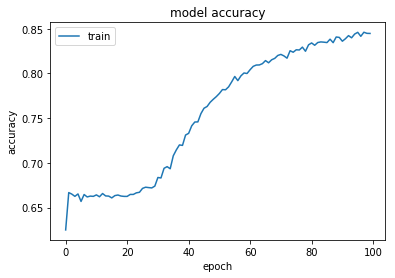

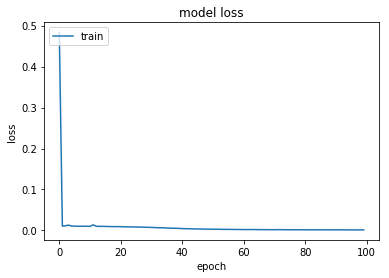

In [0]:
 # summarize history for accuracy
plt.plot(trainedmodels.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodels.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save and Load Model

In [0]:
# Save model
model_VGG19_json = model_VGG19.to_json()
with open("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_VGG19.json", "w") as json_file:
    json_file.write(model_Incep_json)
model_VGG19.save_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_VGG19.h5")

In [0]:
json_file = open('/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_VGG19.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_VGG19.h5")

#### Testing Black and white Images

In [0]:
fig, ax = plt.subplots(11,2,figsize = (16,100))
row = 0
colorize = []
print ("Output of model")

for filename in os.listdir('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test'):
    colorize.append(img_to_array(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename)))
    ax[row , 0].imshow(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename),interpolation='nearest')
    row +=1
    
colorize = np.array(colorize, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*colorize))
colorize_embed = create_VGG19_embedding(gray_me)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict([colorize, colorize_embed])
output = output * 128
row =0


# Output colorizations
for i in range(len(output)):
  create_output = np.zeros((256, 256, 3))
  create_output[:,:,0] = colorize[i][:,:,0]
  create_output[:,:,1:] = output[i]
  Image = lab2rgb(create_output)
  ax[row,1].imshow(Image,interpolation='nearest')
  row +=1

Output hidden; open in https://colab.research.google.com to view.

## AutoEncoder + Xception Network


In [0]:
Xception = Xception(include_top=True, weights='imagenet')
Xception.graph = tf.get_default_graph()

91889664/91884032 [==============================] - 4s 0us/step


#### Build Model

In [0]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)  #filter (64), stride(3,3)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) #now it becomes 32,32,1000
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)  #reshaping output to certain shape
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model_Xception = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

#### Xception Embedding

In [0]:
def create_Xception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with Xception.graph.as_default():
        embed = Xception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size =10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_Xception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]   #grey scale as input
        X_batch = X_batch.reshape(X_batch.shape+(1,))   
        Y_batch = lab_batch[:,:,:,1:] / 128     #a and b as output
        yield ([X_batch, create_Xception_embedding(grayscaled_rgb)], Y_batch)
#iterate over a sequence, but don’t want to store the entire sequence in memory


#Train model      
model_Xception.compile(optimizer='rmsprop', loss='mse',metrics = ['accuracy'])
trainedmodel_Xception= model_Xception.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=100)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 85s 850ms/step - loss: 0.0110 - acc: 0.6542
Epoch 2/100
100/100 [==============================] - 82s 816ms/step - loss: 0.0107 - acc: 0.6621
Epoch 3/100
100/100 [==============================] - 82s 823ms/step - loss: 0.0097 - acc: 0.6635
Epoch 4/100
100/100 [==============================] - 83s 827ms/step - loss: 0.0097 - acc: 0.6599
Epoch 5/100
100/100 [==============================] - 82s 816ms/step - loss: 0.0094 - acc: 0.6624
Epoch 6/100
100/100 [==============================] - 81s 814ms/step - loss: 0.0094 - acc: 0.6611
Epoch 7/100
100/100 [==============================] - 81s 814ms/step - loss: 0.0095 - acc: 0.6633
Epoch 8/100
100/100 [==============================] - 83s 826ms/step - loss: 0.0093 - acc: 0.6618
Epoch 9/100
100/100 [==============================] - 81s 811ms/step - loss: 0.0091 - acc: 0.6653
Epoch 10/100
100/100 [==============================] - 81s 810ms/step - loss: 0.0092 - acc: 0.6616
Epoch 11/100
100/100 

#### AutoEncoder + Xception plotting

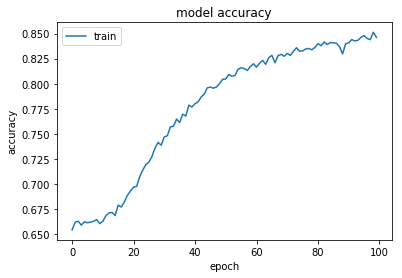

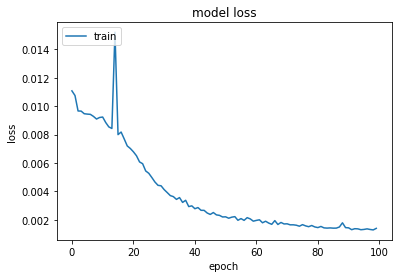

In [0]:
 # summarize history for accuracy
plt.plot(trainedmodel_Xception.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel_Xception.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save and Load Model

In [0]:
# Save model
model_Xception_json = model_Xception.to_json()
with open("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_Xception.json", "w") as json_file:
    json_file.write(model_Xception_json)
model_Xception.save_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_Xception.h5")

In [0]:
json_file = open('/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_Xception.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_Xception.h5")

#### Testing black and white images

In [0]:
fig, ax = plt.subplots(11,2,figsize = (16,100))
row = 0
colorize = []
print ("Output of model")

for filename in os.listdir('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test'):
    colorize.append(img_to_array(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename)))
    ax[row , 0].imshow(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename),interpolation='nearest')
    row +=1
    
colorize = np.array(colorize, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*colorize))
colorize_embed = create_Xception_embedding(gray_me)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict([colorize, colorize_embed])
output = output * 128   #convert into picture
row =0


# Output colorizations
for i in range(len(output)):
  create_output = np.zeros((256, 256, 3))
  create_output[:,:,0] = colorize[i][:,:,0]
  create_output[:,:,1:] = output[i]
  Image = lab2rgb(create_output)
  ax[row,1].imshow(Image,interpolation='nearest')
  row +=1

Output hidden; open in https://colab.research.google.com to view.

## AutoEncoder +  Mobile Networkv2

In [0]:
MobileNetV2 = MobileNetV2(input_shape=None, alpha=1.0, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
MobileNetV2.graph = tf.get_default_graph()

14540800/14536120 [==============================] - 1s 0us/step


#### Build Model

In [0]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model_MobileNetV2 = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

#### MobileNetv2 Embbeding

In [0]:
def create_MobileNetV2_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with MobileNetV2.graph.as_default():
        embed = MobileNetV2.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_MobileNetV2_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_MobileNetV2_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model_MobileNetV2.compile(optimizer='rmsprop', loss='mse',metrics = ['accuracy'])
trainedmodel_MobileNetV2= model_MobileNetV2.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=100)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 65s 650ms/step - loss: 0.1091 - acc: 0.6481
Epoch 2/100
100/100 [==============================] - 62s 618ms/step - loss: 0.0106 - acc: 0.6645
Epoch 3/100
100/100 [==============================] - 62s 620ms/step - loss: 0.0105 - acc: 0.6640
Epoch 4/100
100/100 [==============================] - 62s 618ms/step - loss: 0.0107 - acc: 0.6637
Epoch 5/100
100/100 [==============================] - 62s 615ms/step - loss: 0.0104 - acc: 0.6627
Epoch 6/100
100/100 [==============================] - 63s 629ms/step - loss: 0.0107 - acc: 0.6615
Epoch 7/100
100/100 [==============================] - 62s 618ms/step - loss: 0.0102 - acc: 0.6622
Epoch 8/100
100/100 [==============================] - 62s 617ms/step - loss: 0.0107 - acc: 0.6586
Epoch 9/100
100/100 [==============================] - 62s 616ms/step - loss: 0.0105 - acc: 0.6585
Epoch 10/100
100/100 [==============================] - 61s 610ms/step - loss: 0.0102 - acc: 0.6635
Epoch 11/100
100/100 

#### AutoEncoder + MobileNet plotting

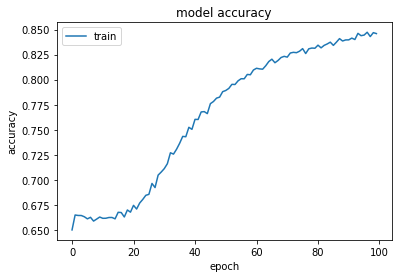

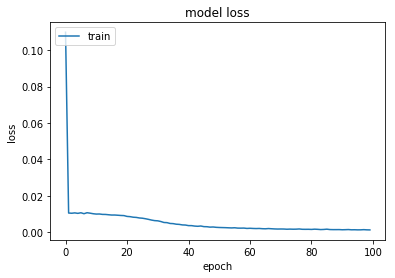

In [0]:
 # summarize history for accuracy
plt.plot(trainedmodel_MobileNetV2.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel_MobileNetV2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save and Load Model 

In [0]:
# Save model
model_MobileNetV2_json = model_MobileNetV2.to_json()
with open("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_MobileNetV2.json", "w") as json_file:
    json_file.write(model_MobileNetV2_json)
model_MobileNetV2.save_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_MobileNetV2.h5")

In [0]:
json_file = open('/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_MobileNetV2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_MobileNetV2.h5")

#### Testing black and white images

In [0]:
fig, ax = plt.subplots(11,2,figsize = (16,100))
row = 0
colorize = []
print ("Output of model")

for filename in os.listdir('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test'):
    colorize.append(img_to_array(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename)))
    ax[row , 0].imshow(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename),interpolation='nearest')
    row +=1
    
colorize = np.array(colorize, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*colorize))
colorize_embed = create_MobileNetV2_embedding(gray_me)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict([colorize, colorize_embed])
output = output * 128
row =0


# Output colorizations
for i in range(len(output)):
  create_output = np.zeros((256, 256, 3))
  create_output[:,:,0] = colorize[i][:,:,0]
  create_output[:,:,1:] = output[i]
  Image = lab2rgb(create_output)
  ax[row,1].imshow(Image,interpolation='nearest')
  row +=1

Output hidden; open in https://colab.research.google.com to view.

## AutoEncoder + Dense Network

In [0]:
DenseNet121 = DenseNet121(inputs = None, include_top=True, weights='imagenet', input_tensor=None, pooling=None, classes=1000)
DenseNet121.graph = tf.get_default_graph()

#### Build Model

In [0]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model_DenseNet121 = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [0]:
def create_DenseNet121_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (224, 224, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with DenseNet121.graph.as_default():
        embed = DenseNet121.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_DenseNet121_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_DenseNet121_embedding(grayscaled_rgb)], Y_batch)


#Train model      
model_DenseNet121.compile(optimizer='rmsprop', loss='mse',metrics = ['accuracy'])
trainedmodel_DenseNet121= model_DenseNet121.fit_generator(image_a_b_gen(batch_size), epochs=100, steps_per_epoch=100)

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


100/100 [==============================] - 73s 734ms/step - loss: 0.1492 - acc: 0.6139
Epoch 2/100
100/100 [==============================] - 66s 656ms/step - loss: 0.0110 - acc: 0.6640
Epoch 3/100
100/100 [==============================] - 67s 668ms/step - loss: 0.0144 - acc: 0.6664
Epoch 4/100
100/100 [==============================] - 67s 675ms/step - loss: 0.0116 - acc: 0.6658
Epoch 5/100
100/100 [==============================] - 67s 673ms/step - loss: 0.0105 - acc: 0.6642
Epoch 6/100
100/100 [==============================] - 67s 672ms/step - loss: 0.0106 - acc: 0.6642
Epoch 7/100
100/100 [==============================] - 67s 670ms/step - loss: 0.0104 - acc: 0.6644
Epoch 8/100
100/100 [==============================] - 66s 656ms/step - loss: 0.0105 - acc: 0.6646
Epoch 9/100
100/100 [==============================] - 68s 680ms/step - loss: 0.0104 - acc: 0.6606
Epoch 10/100
100/100 [==============================] - 67s 670ms/step - loss: 0.0103 - acc: 0.6646
Epoch 11/100
100/100 

#### AutoEncoder + Dense Net plotting

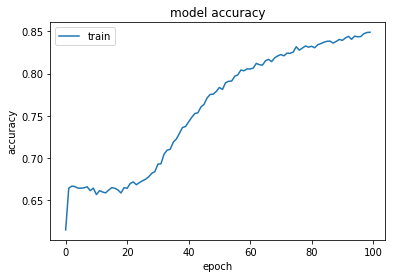

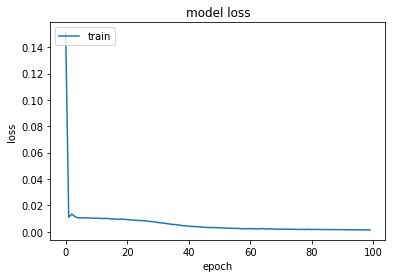

In [0]:
 # summarize history for accuracy
plt.plot(trainedmodel_DenseNet121.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(trainedmodel_DenseNet121.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save and Load Model

In [0]:
# Save model

model_DenseNet121_json = model_DenseNet121.to_json()
with open("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_DenseNet121.json", "w") as json_file:
    json_file.write(model_DenseNet121_json)
model_DenseNet121.save_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_DenseNet121.h5")

In [0]:
from keras.models import model_from_json
json_file = open('/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_DenseNet121.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/Team Drives/DP/ImgConversion/SaveModelFile/model_DenseNet121.h5")

#### Testing black and white images

In [0]:
fig, ax = plt.subplots(11,2,figsize = (16,100))
row = 0
colorize = []
print ("Output of model")

for filename in os.listdir('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test'):
    colorize.append(img_to_array(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename)))
    ax[row , 0].imshow(load_img('/content/drive/Team Drives/DP/ImgConversion/Dataset/Test/Test/'+filename),interpolation='nearest')
    row +=1
    
colorize = np.array(colorize, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*colorize))
colorize_embed = create_DenseNet121_embedding(gray_me)
colorize = rgb2lab(1.0/255*colorize)[:,:,:,0]
colorize = colorize.reshape(colorize.shape+(1,))


# Test model
output = loaded_model.predict([colorize, colorize_embed])
output = output * 128
row =0


# # Output colorizations
for i in range(len(output)):
  create_output = np.zeros((256, 256, 3))
  create_output[:,:,0] = colorize[i][:,:,0]
  create_output[:,:,1:] = output[i]
  Image = lab2rgb(create_output)
  ax[row,1].imshow(Image,interpolation='nearest')
  row +=1 

Output hidden; open in https://colab.research.google.com to view.